In [72]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm 
import hydra
from omegaconf import DictConfig 

#### ODE equations
$\begin{cases}
        S' &= -\beta (1-\sigma) S\Lambda - \nu S\\
        L' &= \beta (1-\sigma) S\Lambda - \kappa L\\
        I' &= p\kappa L - \alpha I - \tau I \\
        A' &= (1-p)\kappa L - \eta A \\
   \end{cases}$ 
   
with $\Lambda = \epsilon L + (1 - q) I + \delta A$

In [73]:
def sliar(y, t, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_interp):
    S, L, I , A = y
    dydt = np.array([- beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - nu_interp(t) * S,
                    beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - kappa * L,
                    p * kappa * L - alpha * I - tau * I,
                    (1 - p) * kappa * L  - eta * A])
    return dydt

#### PMP
##### Optimal control systems
$\min_{u\in\mathcal{U}_{ad}} \int_0^T PI(t) + Q\nu^2(t) + R\tau^2(t) + W\sigma^2(t) dt$

subject to 
$\begin{cases}
        S' &= -\beta (1-\sigma) S\Lambda - \nu S\\
        L' &= \beta (1-\sigma) S\Lambda - \kappa L\\
        I' &= p\kappa L - \alpha I - \tau I \\
        A' &= (1-p)\kappa L - \eta A \\
\end{cases}$

with $\Lambda = \epsilon L + (1 - q) I + \delta A$


#### 1) Hamiltonian

$H = f + \lambda\cdot g$

$ = PI + Q\nu^2 + R\tau^2 + W\sigma^2 + \begin{bmatrix}\lambda_S\\\lambda_L\\\lambda_I\\\lambda_A\end{bmatrix}' \cdot \begin{bmatrix}-\beta (1-\sigma) S\Lambda - \nu S\\ \beta (1-\sigma) S\Lambda - \kappa L\\ p\kappa L - \alpha I - \tau I \\ (1-p)\kappa L - \eta A \end{bmatrix}$

#### 2) Optimality condition

$\frac{\partial H}{\partial \nu} = 0$ at optimal $\nu^*$

$\frac{\partial H}{\partial \nu} = 2  Q  \nu - \lambda_S S$

#### 3) Adjoint equation

$\lambda' = -\frac{\partial H}{\partial x}$

$=$
$\begin{cases}
        \frac{\partial H}{\partial S} &= \beta (1-\sigma) (\epsilon L + (1 - q) I \delta A) (\lambda_S - \lambda_L) + \nu \lambda_S\\
        \frac{\partial H}{\partial L} &= \beta (1-\sigma) \epsilon S (\Lambda_S - \lambda_L) - \kappa p (\lambda_I - \lambda_A) + \kappa (\lambda_L - \lambda_A)\\
        \frac{\partial H}{\partial I} &= - P  + \beta (1-\sigma) (1 - q) S (\lambda_S - \lambda_L) + \lambda_I (\alpha + \tau)\\
        \frac{\partial H}{\partial A} &= \beta (1-\sigma) \delta S (\lambda_S - \lambda_L) + \eta \lambda_A \\
\end{cases}$

$x$ : States

In [74]:
def adjoint_sliar(y, t, x_interp, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_interp):
    l_S, l_L, l_I, l_A  = y
    S, L, I, A = x_interp(t)
    nu = nu_interp(t)
    dHdS = beta * (1 - sigma) * (epsilon * L + (1 - q) * I + delta * A) * (l_S - l_L) + nu * l_S
    dHdL = beta * (1 - sigma) * epsilon * S * (l_S - l_L) - kappa * p * (l_I - l_A) + kappa * (l_L - l_A)
    dHdI = -P + beta * (1 - q) * (1 - sigma) * S * (l_S - l_L) + l_I * (alpha + tau)
    dHdR = beta * (1 - sigma) * delta * S * (l_S - l_L) + eta * l_A
    return np.array([dHdS, dHdL, dHdI, dHdR])

#### 4) Transversality condition

$\lambda(t_1) = 0$

#### 5) State equation

$x' = g(t,x,u) = \frac{\partial H}{\partial \lambda}$

$x(t_0) = x_0$

$x_0 = [S_0, L_0, I_0, A_0]$

$S_0 = 100,000, L_0 = 0,  I_0 = 1,  A_0 = 0$

In [75]:
# Parameter Initial
t0 = 0
tf = 300
S0 = 1000000
L0 = 0
I0 = 1
A0 = 0
sigma = 0 
kappa = 0.526
alpha = 0.244
tau = 0
p = 0.667
eta = 0.244
epsilon = 0
q = 0.5
delta = 1
R0 = 1.9847
beta = R0/(S0 * ((epsilon / kappa) + ((1 - q)*p/alpha) + (delta*(1-p)/eta)))
P = 1
Q = 1E6

# Initial
y0 = np.array([S0, L0, I0, A0])
t = np.linspace(t0, tf, 301)
dt = t[1] - t[0]

<Figure size 640x480 with 0 Axes>

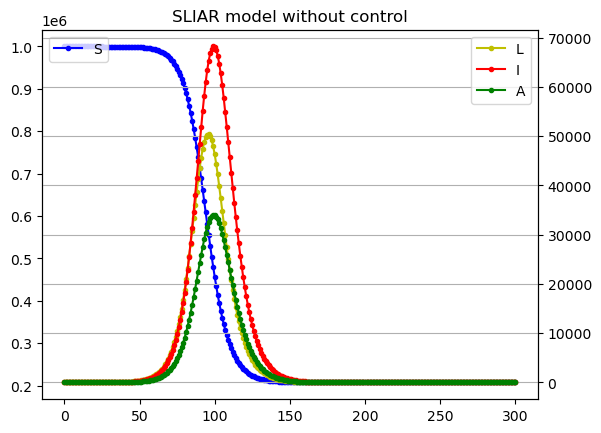

array([[1.00000000e+06, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.99999665e+05, 2.58671650e-01, 8.29994330e-01, 2.32184847e-02],
       [9.99999346e+05, 4.01476938e-01, 7.55668385e-01, 7.08014473e-02],
       ...,
       [2.07411026e+05, 9.95858481e-06, 2.71574583e-05, 1.35583712e-05],
       [2.07411026e+05, 8.87270923e-06, 2.41961069e-05, 1.20799154e-05],
       [2.07411026e+05, 7.90841444e-06, 2.15663196e-05, 1.07669932e-05]])

In [76]:
# Without Control
nu0_ = np.zeros_like(t)
nu_intp = lambda tc: np.interp(tc, t, nu0_)
sol = odeint(sliar, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))

# Result
plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol[:,1], '.-y', label = 'L')
ax2.plot(t, sol[:,2], '.-r', label = 'I')
ax2.plot(t, sol[:,3], '.-g', label = 'A')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model without control')
plt.xlabel('day')
plt.savefig('SLIAR_wo_control_adj.png', dpi=300)
plt.show(block=False)

sol

#### Simple Gradient Method

step1. Set the initial $u_0$

step2. (Forward) Solve the State differential equation

step3. (Backward) Solve the Adjoint differential equation

step4. Update u0 (Using Gradient Method)

    for
        nu1 <- nu0 - dHdnu * stepsize
        Calculate cost
        
        if oldcost < cost:
            stepsize <- stepsize / rate
        
        if oldcost > cost:
            break
    
    # convergence check
    if oldcost - cost < tol:
        break
            
    nu0 <- nu1
    old_cost <- cost

step5. Check the convergence

In [77]:
MaxIter = 100000
step_size = 0.5
#old_cost = 1E8
costs = []

# Set the initial nu0
nu0 = 0.01 * np.ones_like(t)
# np.where(조건, true결과, false결과)
nu0 = np.where(t > 10, 0, 1)
#nu0


In [78]:
# Simple gradient method
for it in range(MaxIter + 1):
    # State (Forward)
    nu_intp = lambda tc: np.interp(tc, t, nu0)
    sol = odeint(sliar, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))

    # Adjoint (Backward)
    nu_intp = lambda tc: np.interp(tf - tc, t, nu0)
    x_intp = lambda tc: np.array([np.interp(tf - tc, t, sol[:, 0]), 
                                    np.interp(tf - tc, t, sol[:, 1]), 
                                    np.interp(tf - tc, t, sol[:, 2]), 
                                    np.interp(tf - tc, t, sol[:, 3])])
    # lambda_terminal = 0
    y_T = np.array([0,0,0,0])
    l_sol = odeint(adjoint_sliar, y_T, t, args=(x_intp, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))
    l_sol = np.flipud(l_sol)

    # Cost for nu0
    S, L, I, A = np.hsplit(sol, 4)
    S_mid = (S[1:] + S[:-1]) / 2.
    L_mid = (L[1:] + L[:-1]) / 2.
    I_mid = (I[1:] + I[:-1]) / 2.
    A_mid = (A[1:] + A[:-1]) / 2.
    nu_mid = (nu0[1:] + nu0[:-1]) / 2.
    cost1 = dt * np.sum(I_mid.flatten())
    cost2 = dt * np.sum(nu_mid.flatten() ** 2)
    old_cost = P * cost1 + Q * cost2

    # nu update loop 
    # old_cost > cost인 nu1 찾으면 loop out
    # FOR optimality condition
    # dHdnu    
    contIt = 0
    while contIt < MaxIter:
        print(contIt)
        Hnu = 2 * Q * nu0 - l_sol[:, 0] * sol[:, 0]
        # Update nu0
        nu1 = np.clip(nu0 - step_size * Hnu , 0, 0.01)
        # State (Forward)
        nu_intp = lambda tc: np.interp(tc, t, nu1)
        sol1 = odeint(sliar, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))
        # Cost for nu0
        S, L, I, A = np.hsplit(sol1, 4)
        S_mid = (S[1:] + S[:-1]) / 2.
        L_mid = (L[1:] + L[:-1]) / 2.
        I_mid = (I[1:] + I[:-1]) / 2.
        A_mid = (A[1:] + A[:-1]) / 2.
        nu_mid = (nu1[1:] + nu1[:-1]) / 2.
        cost1 = dt * np.sum(I_mid.flatten())
        cost2 = dt * np.sum(nu_mid.flatten() ** 2)
        cost = cost1 + Q * cost2

        # old_cost : 이전 cost, cost : 새롭게 선택된 u1을 u0로 만든 cost
        # old_cost > cost --> learning rate 더 줄이기
        print(old_cost)
        print(cost)

        if old_cost < cost:
            step_size = step_size / 5 # simple adaptive step size
        
        print('step size:' + str(step_size))
        
        if old_cost >= cost:
            break

        contIt = contIt + 1

    # Convergence
    if np.abs(old_cost - cost) <= 1E-5:
        break

    old_cost = cost
    costs.append(old_cost)
    nu0 = nu1

0
10250004.977920135
11308.78444457589
step size:0.5
0
11308.78444457589
31655.293406740966
step size:0.1
1
11308.78444457589
31533.003325386777
step size:0.02
2
11308.78444457589
31351.05459726729
step size:0.004
3
11308.78444457589
31157.525958238224
step size:0.0008
4
11308.78444457589
30956.57614114533
step size:0.00016
5
11308.78444457589
30752.833821168097
step size:3.2000000000000005e-05
6
11308.78444457589
30548.496604228316
step size:6.400000000000001e-06
7
11308.78444457589
30336.974942133853
step size:1.2800000000000002e-06
8
11308.78444457589
30122.78521993072
step size:2.5600000000000007e-07
9
11308.78444457589
29910.18408037819
step size:5.1200000000000015e-08
10
11308.78444457589
29699.0168493435
step size:1.0240000000000003e-08
11
11308.78444457589
29489.119608272278
step size:2.0480000000000004e-09
12
11308.78444457589
29280.34175306428
step size:4.0960000000000006e-10
13
11308.78444457589
29072.54970130941
step size:8.192000000000001e-11
14
11308.78444457589
28865.625

<Figure size 640x480 with 0 Axes>

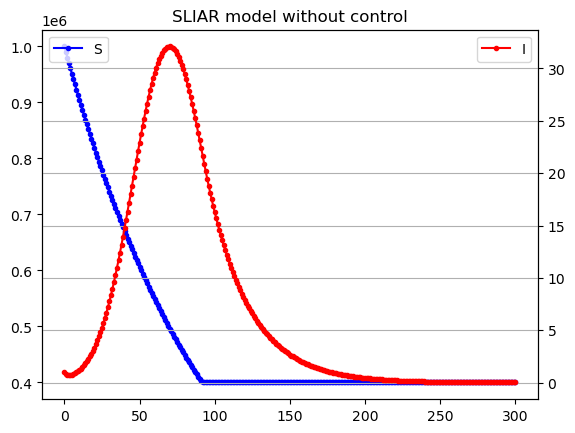

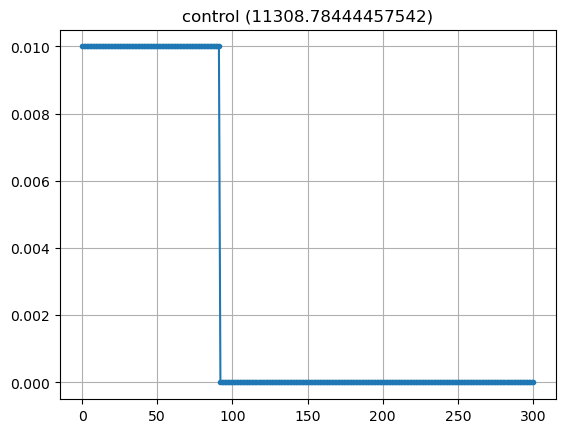

In [79]:
nu_intp = lambda tc: np.interp(tc, t, nu0)
sol = odeint(sliar, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))
# Cost for nu0
S, L, I, A = np.hsplit(sol, 4)
S_mid = (S[1:] + S[:-1]) / 2.
L_mid = (L[1:] + L[:-1]) / 2.
I_mid = (I[1:] + I[:-1]) / 2.
A_mid = (A[1:] + A[:-1]) / 2.
nu_mid = (nu0[1:] + nu0[:-1]) / 2.
cost1 = dt * np.sum(I_mid.flatten())
cost2 = dt * np.sum(nu_mid.flatten() ** 2)
old_cost = cost1 + Q * cost2

plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol[:,2], '.-r', label = 'I')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model without control')
plt.xlabel('day')
plt.savefig('SLIAR_w_control_adj.png', dpi=300)
plt.show(block=False)


plt.plot(t, nu0, '.-')
plt.title('control ('+ str(cost)+')')
plt.grid()
plt.show()